## RQ3 Full Process

General plan:
- Load the tokens for class 3 and 6 (created in RQ2)
- Assign each token their cluster from RQ2
- Isolate the clusters I'm interested in 
- Compare those clusters (word cloud, cluster membership metric?)

To do: think about how to handle the max class - should it be the max across all classes, the max across class 3, 4, 5, 6 or the max between 3 and 6

In [2]:
# SETUP

# Import packages
import pandas as pd
import pickle

import spacy
from deep_translator import GoogleTranslator
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Load 2 sets of tokens for class 3 and 6

These were created as part of RQ2.

In [3]:
# STEP 1: LOAD CLASS TOKENS

filtered_tokens_lc_c3 = pickle.load(open("./processing/final_tokens_c3.p", "rb"))
filtered_tokens_lc_c6 = pickle.load(open("./processing/final_tokens_c6.p", "rb"))


In [4]:
# STEP 1: CHECK GENERAL RESULTS

word_freq_c3 = Counter(filtered_tokens_lc_c3)
common_words_c3 = word_freq_c3.most_common(20)

word_freq_c6 = Counter(filtered_tokens_lc_c6)
common_words_c6 = word_freq_c6.most_common(20)

common_words_c3[0:9], common_words_c6[0:9]

([('wanderung', 9),
  ('weg', 6),
  ('to', 5),
  ('entlang', 4),
  ('rauhkopf', 4),
  ('jaegerkamp', 4),
  ('linderhof', 4),
  ('m', 3),
  ('bartholomä', 3)],
 [('weg', 154),
  ('blick', 111),
  ('aussicht', 100),
  ('parkplatz', 84),
  ('burg', 82),
  ('rechts', 70),
  ('wald', 69),
  ('entlang', 68),
  ('schöne', 68)])

### Step 2: Assign clusters

Assign each token their cluster from rq2_step2_text_analysis.ipynb

In [5]:
# STEP 2: LOAD TOKEN/CLUSTER LOOKUP FROM RQ2

token_cluster_lookup = pickle.load(open("./processing/token_cluster_all.p", "rb"))

token_cluster_lookup_dict = token_cluster_lookup.set_index("token").to_dict()["cluster"]

token_cluster_lookup_dict

{'breite': 8,
 'forstwege': 3,
 'pfade': 10,
 'halber': 12,
 'strecke': 10,
 'einkehren': 8,
 'montag': 12,
 'ruhetag': 3,
 'rinken': 6,
 'schauinsland': 6,
 'arten': 0,
 'menschen': 8,
 'geeignet': 8,
 'gipfel': 3,
 'abgerundet': 8,
 'bietet': 8,
 'guten': 12,
 'blick': 13,
 'schwarzen': 12,
 'dschungel': 0,
 'nördlichen': 8,
 'hang': 3,
 'schweizer': 12,
 'berge': 3,
 'liechtenstein': 8,
 'feldberg': 3,
 'm': 2,
 'schwarzes': 12,
 'deutschland': 8,
 'linke': 12,
 'gabelung': 7,
 'feldsee': 6,
 'see': 0,
 'bank': 4,
 'top': 9,
 'monolith': 1,
 'titisee': 6,
 'camping': 3,
 'teich': 0,
 'ruhestein': 6,
 'bartholomä': 6,
 'schönen': 5,
 'fuss': 3,
 'watzmann': 3,
 'ostwand': 1,
 'gleichem': 8,
 'weg': 10,
 'entlang': 7,
 'richtung': 7,
 'norden': 7,
 'beginnt': 8,
 'wald': 0,
 'zunehmend': 8,
 'ausgesetzter': 3,
 'wanderer': 3,
 'höhenangst': 12,
 'steig': 3,
 'erreicht': 8,
 'schließlich': 12,
 'aussichtspunkt': 3,
 'schöner': 5,
 'aussicht': 5,
 'königssee': 6,
 'minuten': 12,
 'schön

In [6]:
# STEP 2: MAP TOKENS TO CLUSERS

# Create a df with tokens as one column
final_tokens_c3_df = pd.DataFrame({'token': filtered_tokens_lc_c3})
final_tokens_c6_df = pd.DataFrame({'token': filtered_tokens_lc_c6})

# Add cluster column using dictionary as lookup
final_tokens_c3_df["cluster"] = final_tokens_c3_df["token"].map(token_cluster_lookup_dict)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["token"].map(token_cluster_lookup_dict)

# Remove NaN entries (these are ones that were missing from the model during vectorisation)
final_tokens_c3_df = final_tokens_c3_df.dropna()
final_tokens_c6_df = final_tokens_c6_df.dropna()

# Convert cluster number to int
final_tokens_c3_df["cluster"] = final_tokens_c3_df["cluster"].astype(int)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["cluster"].astype(int)

final_tokens_c3_df

,token,cluster
0,breite,8
1,forstwege,3
2,pfade,10
3,halber,12
4,strecke,10
...,...,...
468,oktober,8
469,museum,1
470,jena,8
471,jena,8


### Step 3: Isolate clusters of interest

At the moment I'm not sure of the final clusters so the actual clusters of interest might change - the ones used now are just placeholders so I can get the process ready.


In [10]:
# STEP 3: FILTER SPECIFIC CLUSTERS

# Extract the clusters of interest
filtered_clusters_c3 = final_tokens_c3_df[(final_tokens_c3_df["cluster"]==0) | (final_tokens_c3_df["cluster"]==1) | (final_tokens_c3_df["cluster"]==5)]
filtered_clusters_c6 = final_tokens_c6_df[(final_tokens_c6_df["cluster"]==0) | (final_tokens_c6_df["cluster"]==1) | (final_tokens_c6_df["cluster"]==5)]

filtered_clusters_c3

,token,cluster
14,arten,0
23,dschungel,0
38,see,0
39,see,0
42,monolith,1
...,...,...
449,truppenübungsplatz,0
456,kliff,0
460,prosecco,5
469,museum,1


### Step 4: Compare Class 3 and 6 Results

wordcloud
within cluster membership metric?

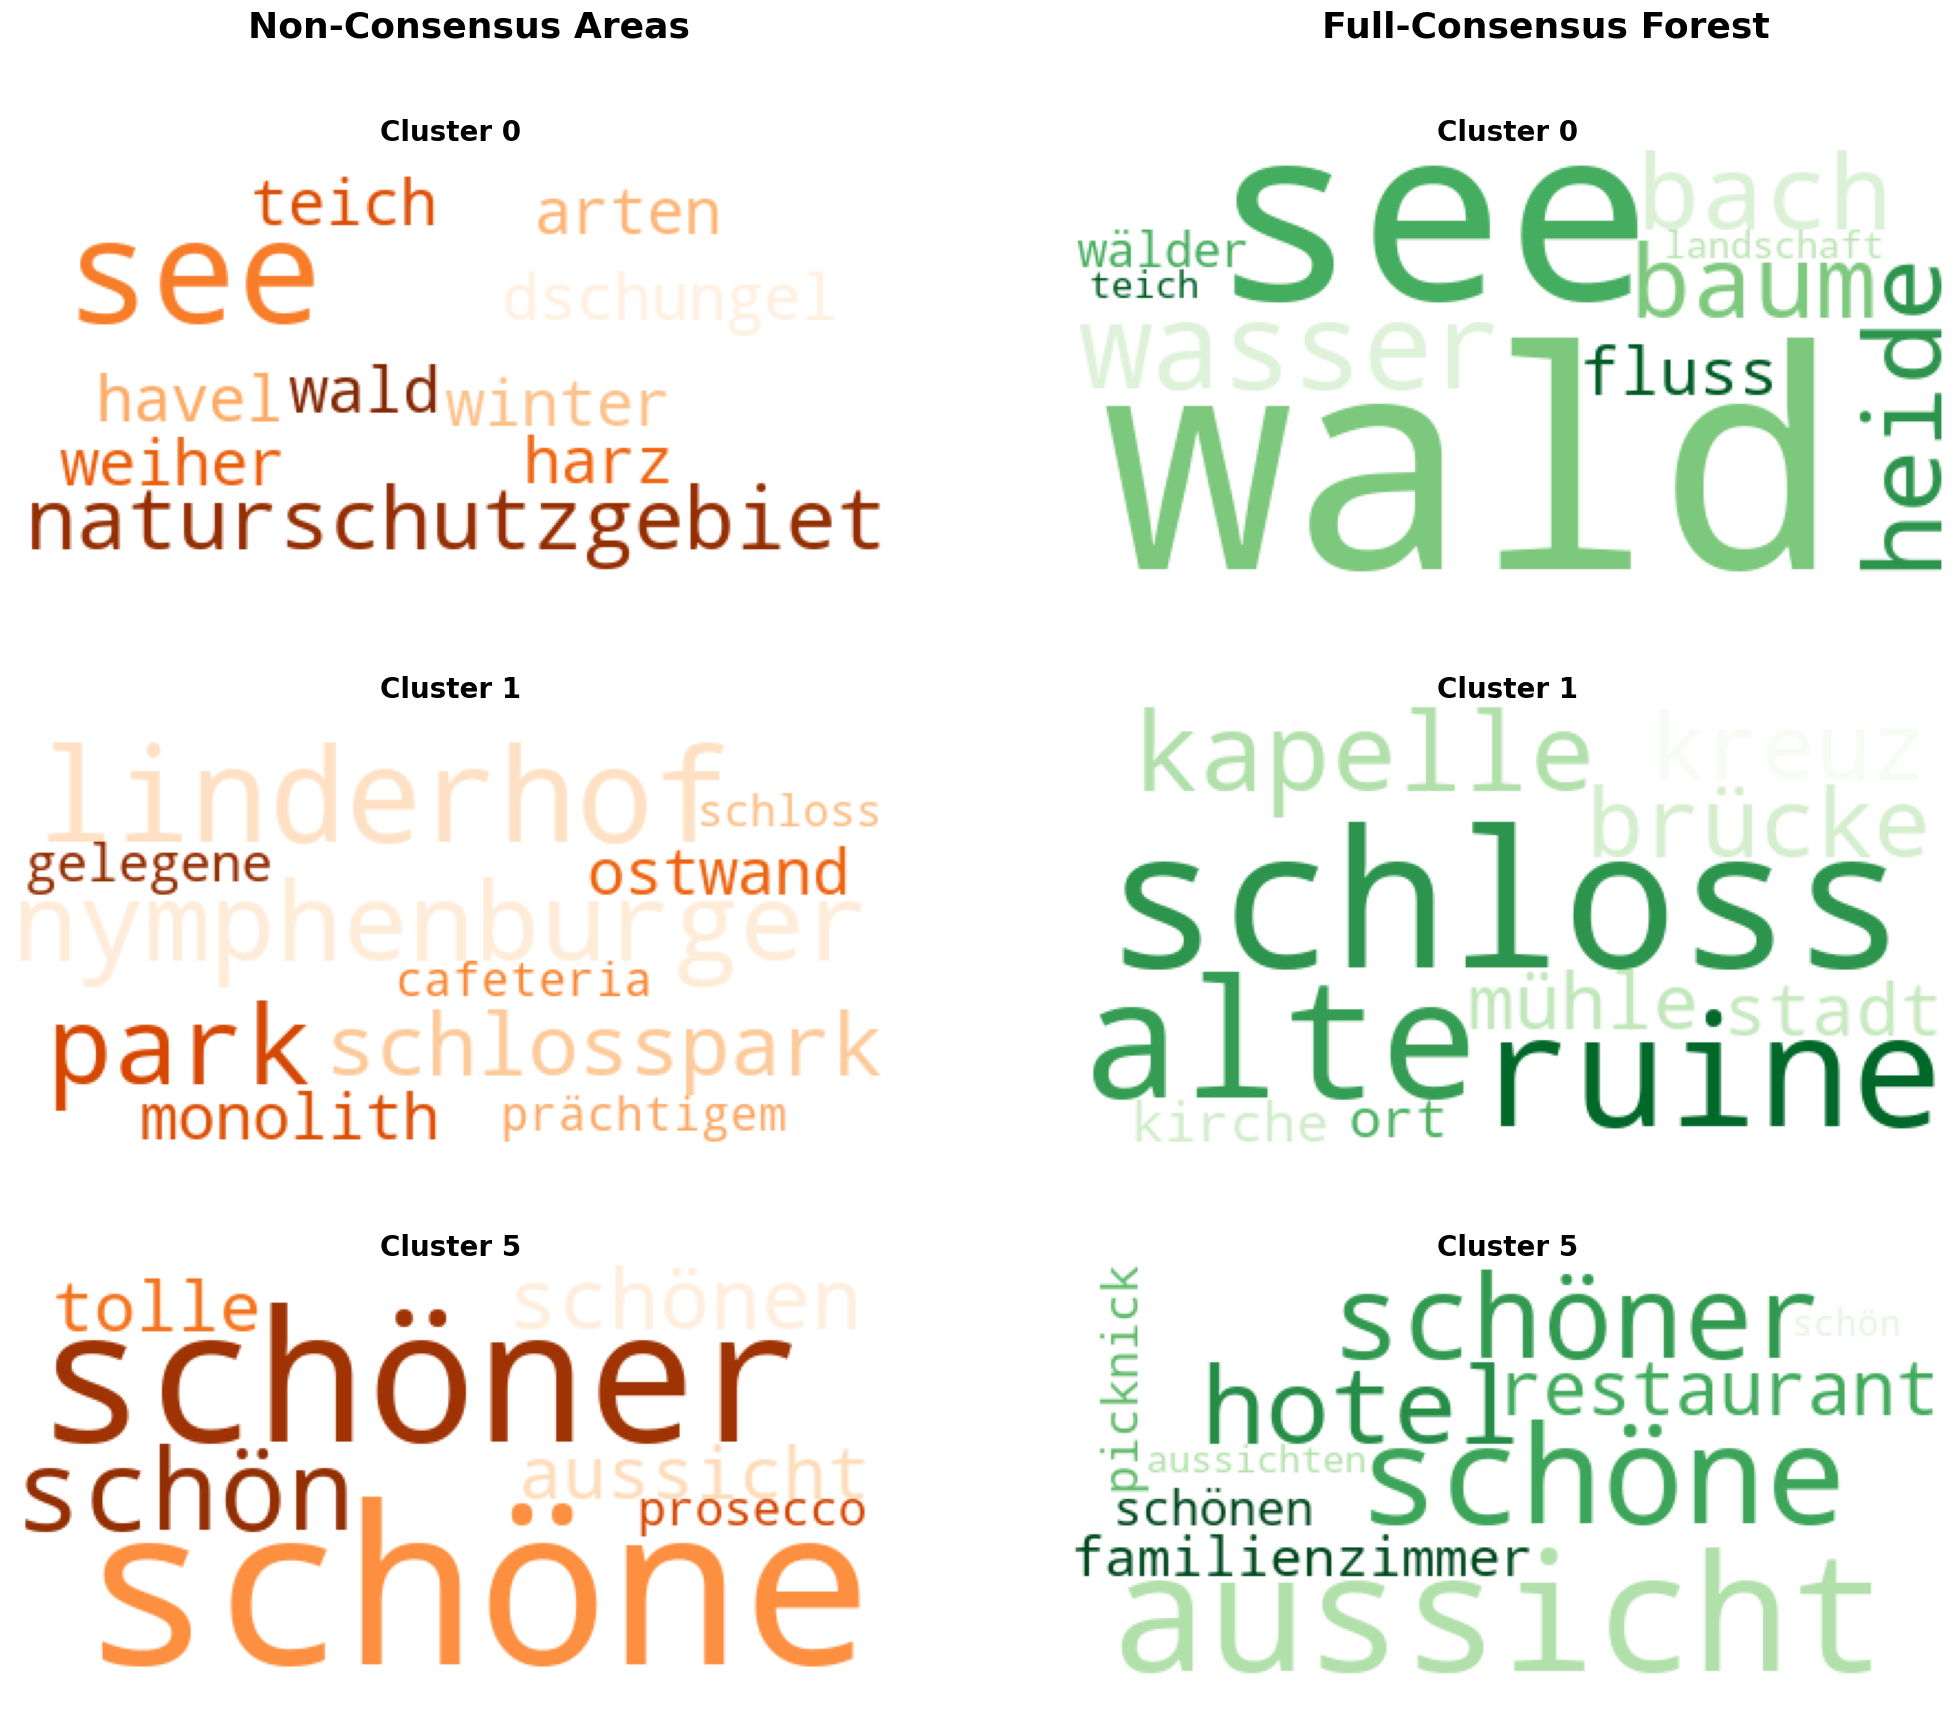

In [100]:
# STEP 3: WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc_c3 = []
all_wc_c6 = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER

# Generate class 3 word clouds
for clus_num in [0,1,5]:  
    freqs = get_cluster_freq(filtered_clusters_c3, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Oranges', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c3.append(wc)

# Generate class 6 word clouds
for clus_num in [0,1,5]:  
    freqs = get_cluster_freq(filtered_clusters_c6, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Greens', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c6.append(wc)

# Create custom titles (shared for both c3 and c6)
all_titles = ["Cluster 0", "Cluster 1", "Cluster 5"]

# Create a single figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 20))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(3):
    # Class 3 word clouds
    axes[i, 0].imshow(all_wc_c3[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")

    # Class 6 word clouds
    axes[i, 1].imshow(all_wc_c6[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")


# Adjust white space at the top to fit in main titles and adjust space between rows
plt.subplots_adjust(top=0.90, hspace=0.2)

# Add column titles (first two numbers control the position)
fig.text(0.22, 0.95, "Non-Consensus Areas", fontsize=26, fontweight='bold')
fig.text(0.65, 0.95, "Full-Consensus Forest", fontsize=26, fontweight='bold')

plt.show()

In [ ]:
# STEP 3: CLASS COMPARISON

# Get the total counts across all clusters for each class
c3_total_token_count = len(filtered_clusters_c3)
c6_total_token_count = len(filtered_clusters_c6)

print(f"Total Tokens for Class 3: {c3_total_token_count}")
print(f"Total Tokens for Class 6: {c6_total_token_count}")

Total Tokens for Class 3: 69
Total Tokens for Class 6: 2705


In [ ]:
# STEP 3: CLUSTER COMPARISON

# Create dfs for storing total number of tokens for each cluster for each class
c3_token_counts_df = pd.DataFrame()
c6_token_counts_df = pd.DataFrame()

# Create column for cluster names (UPDATE LATER)
c3_token_counts_df["cluster_name"] = ["Cluster 0", "Cluster 1", "Cluster 5"]
c6_token_counts_df["cluster_name"] = ["Cluster 0", "Cluster 1", "Cluster 5"]

# Create empty list for storing counts per cluster for each class
c3_token_counts = []
c6_token_counts = []

# Count tokens per cluster and append to list (class 3)
for clus_num in [0,1,5]:
    count = len(filtered_clusters_c3[filtered_clusters_c3["cluster"] == clus_num])
    c3_token_counts.append(count)

# Count tokens per cluster and append to list (class 6)
for clus_num in [0,1,5]:
    count = len(filtered_clusters_c6[filtered_clusters_c6["cluster"] == clus_num])
    c6_token_counts.append(count)

# Combine count lists and add to dfs
c3_token_counts_df["token_count"] = c3_token_counts 
c6_token_counts_df["token_count"] = c6_token_counts 

# Check
#c3_token_counts_df, c6_token_counts_df


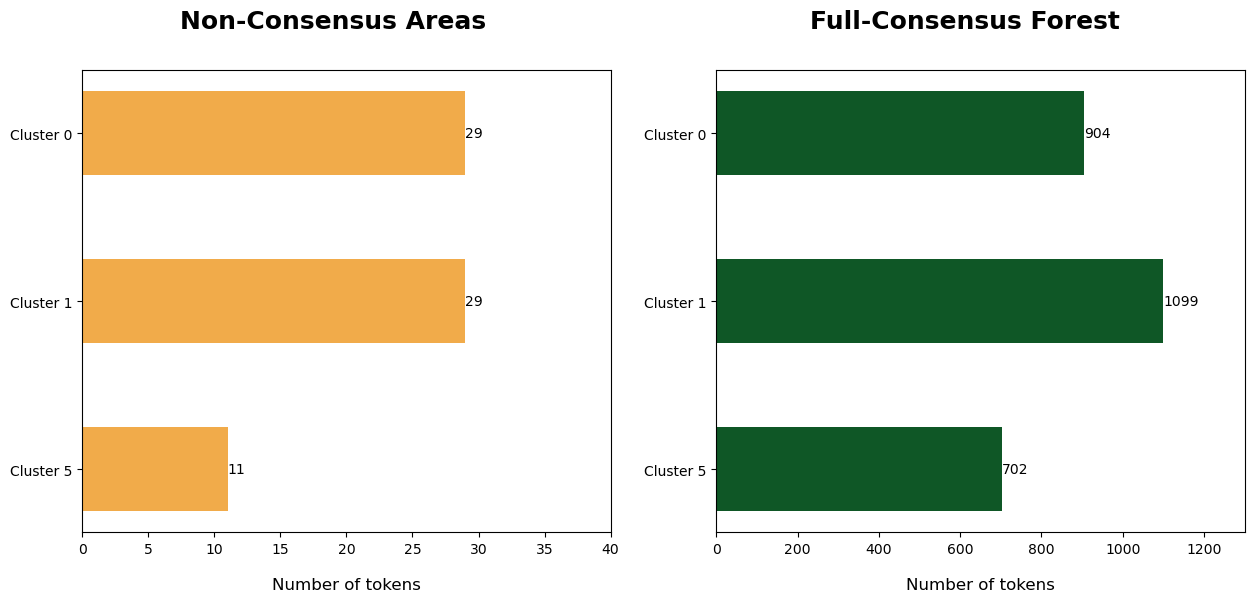

In [172]:
# STEP 3: CLUSTER COMPARISON
# Create horizontal bar charts for token counts per cluster for each class

# Set up fig and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Set up horizontal bar charts
bar_chart_c3 = axes[0].barh(c3_token_counts_df["cluster_name"], 
                            c3_token_counts_df["token_count"],
                            color = "#F1AB4A",
                            height = 0.5)

bar_chart_c6 = axes[1].barh(c6_token_counts_df["cluster_name"], 
                            c6_token_counts_df["token_count"],
                            color = "#0F5726",
                            height = 0.5)

# Customise yaxis order, set up labels and extend xlim to fit value labels
axes[0].invert_yaxis()  
axes[0].set_xlabel('Number of tokens', fontsize=12, labelpad=15)
axes[0].bar_label(bar_chart_c3)
axes[0].set_xlim(right=40) 

axes[1].invert_yaxis() 
axes[1].set_xlabel('Number of tokens', fontsize=12, labelpad=15)
axes[1].bar_label(bar_chart_c6)
axes[1].set_xlim(right=1300) 

# Add column titles (first two numbers control the position)
fig.text(0.19, 0.95, "Non-Consensus Areas", fontsize=18, fontweight='bold')
fig.text(0.61, 0.95, "Full-Consensus Forest", fontsize=18, fontweight='bold')

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_cluster_counts_per_class.png', bbox_inches='tight')

# Show plot
plt.show()


In [131]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON

# Create function for getting the frequenies for each token (using another function from above)
def cluster_token_freqs(df, clus_range):
    clus_freqs = []
    for clus_num in clus_range:
        clus_freq = get_cluster_freq(df, clus_num)
        clus_freqs.append(clus_freq)
    return clus_freqs

# Run the cluster_token_freqs function for class 3 and 6
c3_clus0, c3_clus1, c3_clus5 = cluster_token_freqs(filtered_clusters_c3, [0,1,5])
c6_clus0, c6_clus1, c6_clus5 = cluster_token_freqs(filtered_clusters_c6, [0,1,5])

# Create function for generating dfs with top 10 tokens from each cluster 
def top10_tokens(counter_obj):
    top10_df = pd.DataFrame.from_records(counter_obj.most_common(10), columns=['token','count'])
    return top10_df

# Use function for creating dfs per class and cluster
c3_clus0_top10_df = top10_tokens(c3_clus0)
c3_clus1_top10_df = top10_tokens(c3_clus1)
c3_clus5_top10_df = top10_tokens(c3_clus5)

c6_clus0_top10_df = top10_tokens(c6_clus0)
c6_clus1_top10_df = top10_tokens(c6_clus1)
c6_clus5_top10_df = top10_tokens(c6_clus5)

# Check
c3_clus5_top10_df


,token,count
0,schöne,3
1,schöner,2
2,schön,2
3,schönen,1
4,aussicht,1
5,tolle,1
6,prosecco,1


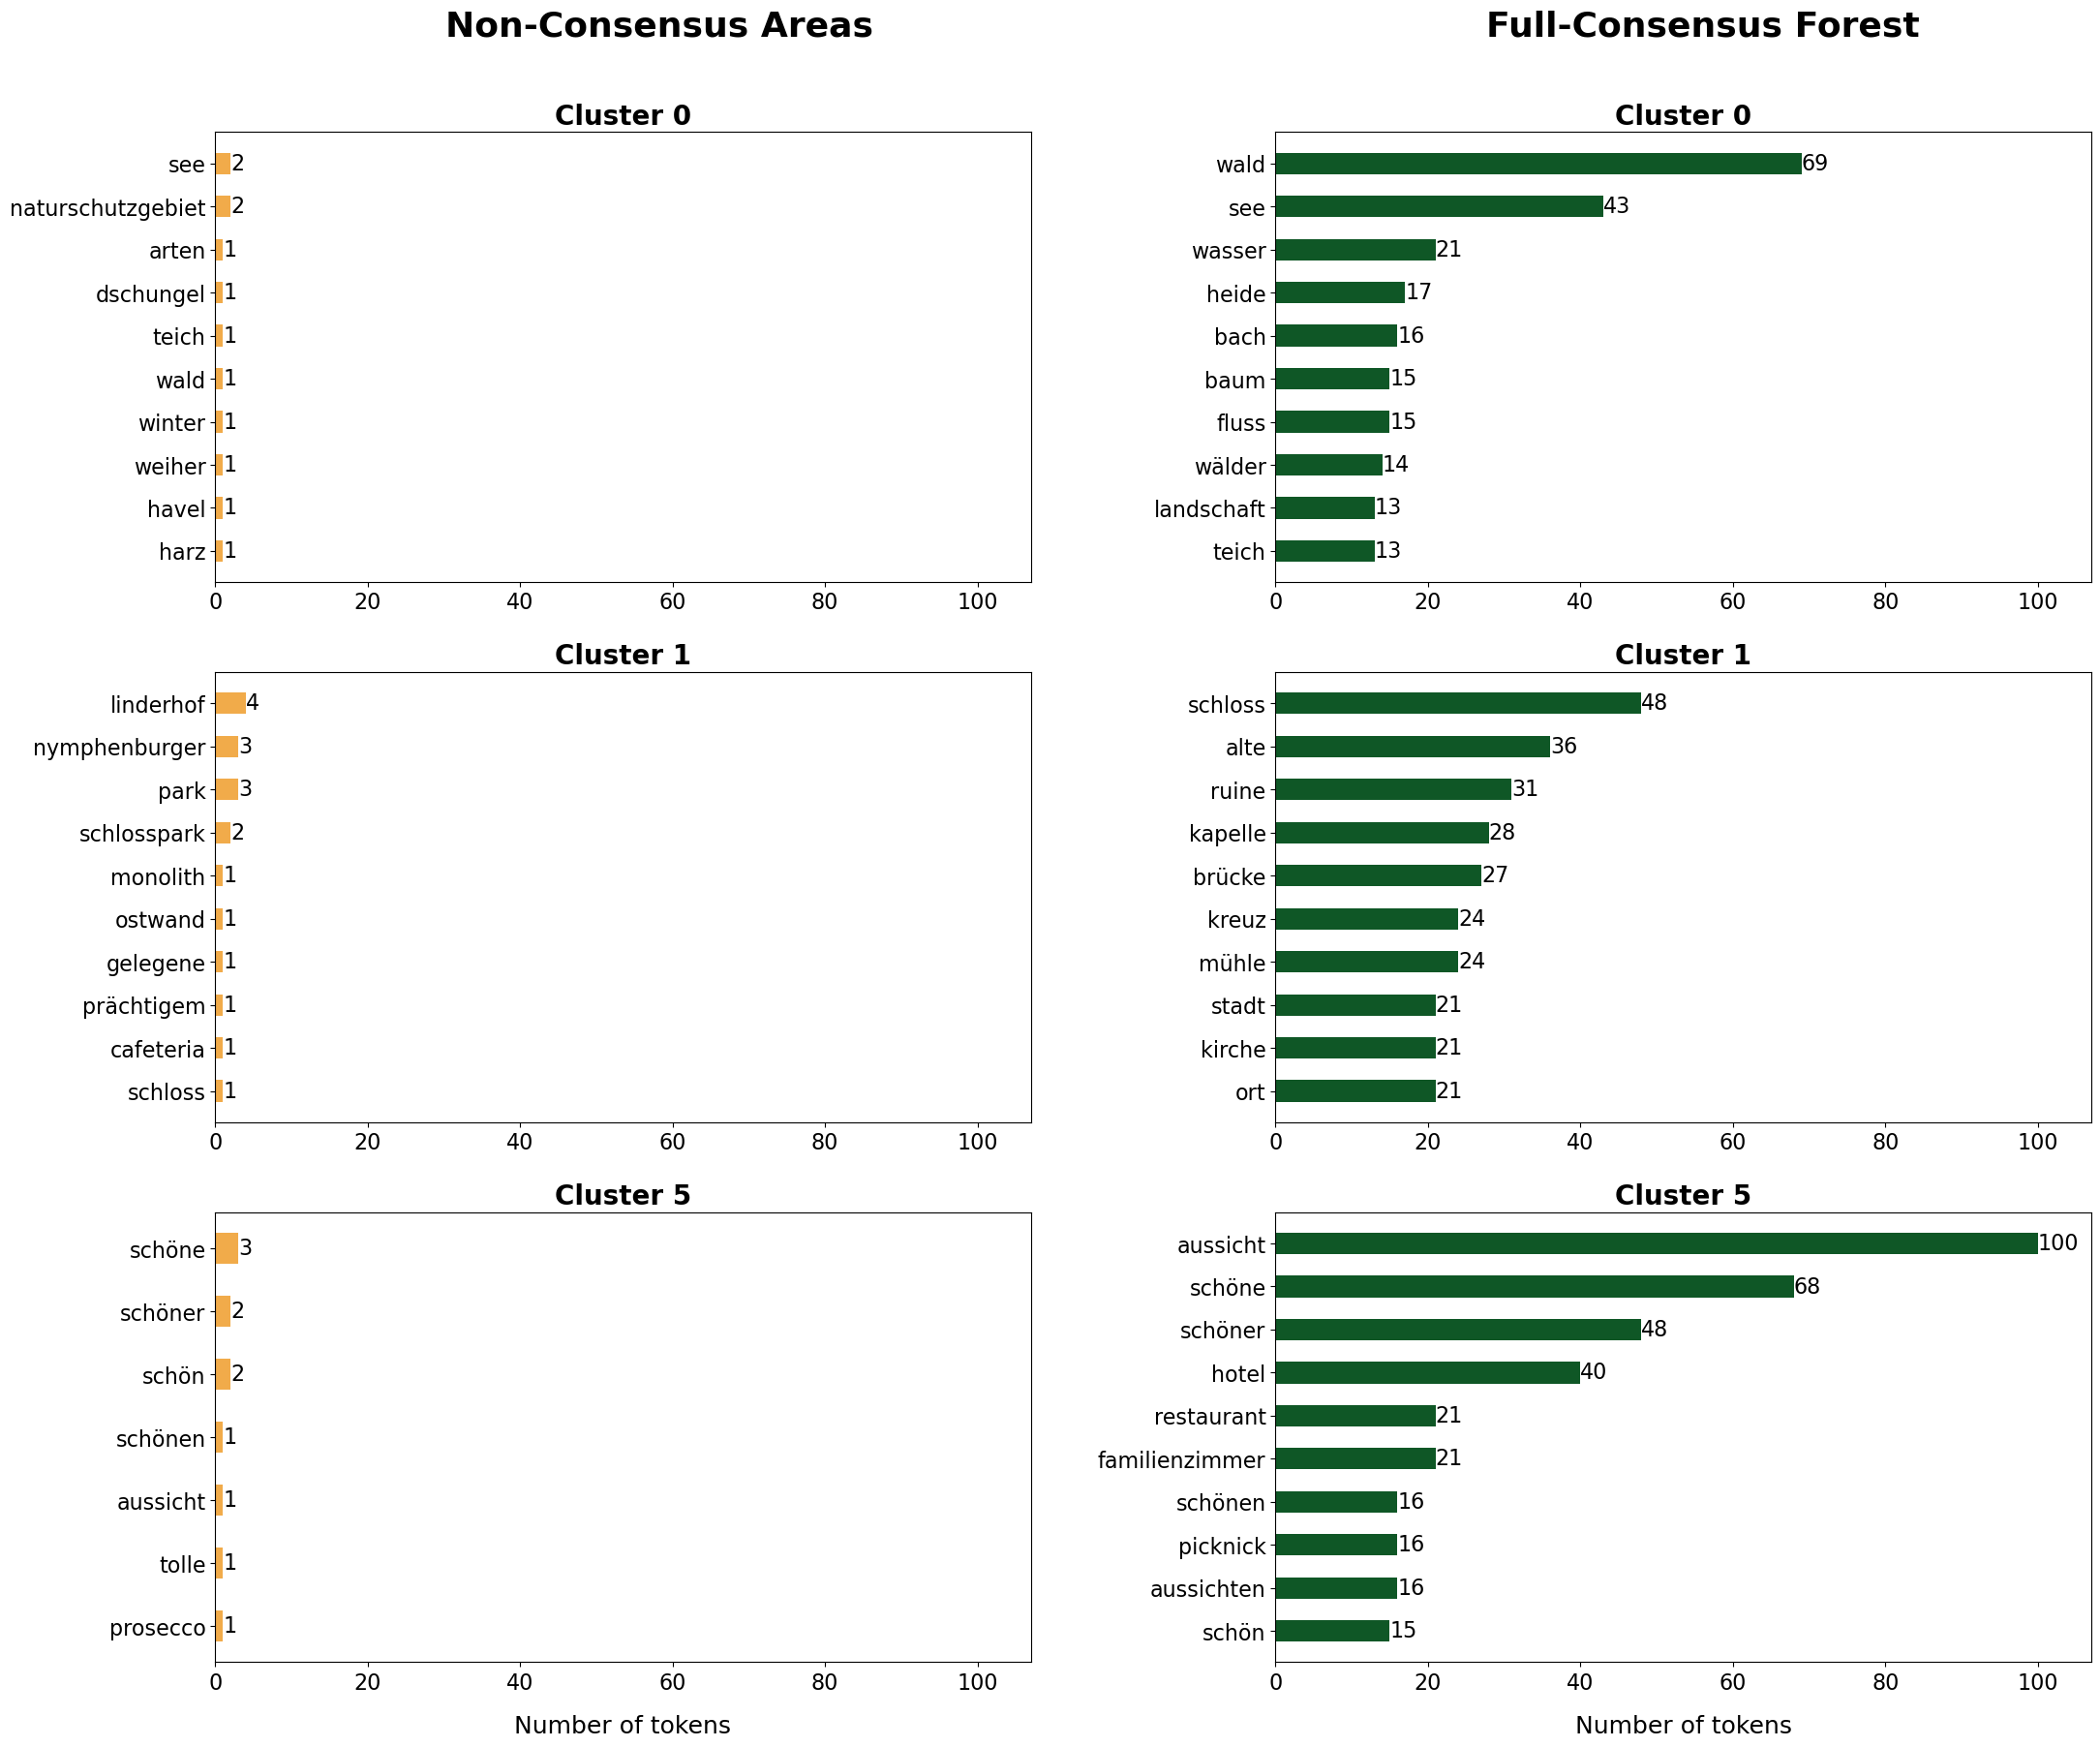

In [ ]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON
# Create horizontal bar charts for individual token counts per cluster for each class

# Create a list of the dfs to plot (one per class)
c3_token_count_list = [c3_clus0_top10_df, c3_clus1_top10_df, c3_clus5_top10_df]
c6_token_count_list = [c6_clus0_top10_df, c6_clus1_top10_df, c6_clus5_top10_df]

# Create custom titles (shared for both c3 and c6)
all_titles = ["Cluster 0", "Cluster 1", "Cluster 5"]

# Create a single figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 20))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(3):
    # Class 3 plots
    bar_chart_c3 = axes[i, 0].barh(c3_token_count_list[i]["token"], 
                                   c3_token_count_list[i]["count"],
                                   color = "#F1AB4A",
                                   height = 0.5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")
    axes[i, 0].set_xlim(right=107)
    axes[i, 0].bar_label(bar_chart_c3, fontsize=16)
    axes[i, 0].tick_params(axis='y', labelsize=16)
    axes[i, 0].tick_params(axis='x', labelsize=16)
    axes[2, 0].set_xlabel('Number of tokens', fontsize=18, labelpad=15)

    # Class 6 plots
    bar_chart_c6 = axes[i, 1].barh(c6_token_count_list[i]["token"], 
                                   c6_token_count_list[i]["count"],
                                   color = "#0F5726",
                                   height = 0.5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")
    axes[i, 1].set_xlim(right=107)
    axes[i, 1].bar_label(bar_chart_c6, fontsize=16)
    axes[i, 1].tick_params(axis='y', labelsize=16)
    axes[i, 1].tick_params(axis='x', labelsize=16)
    axes[2, 1].set_xlabel('Number of tokens', fontsize=18, labelpad=15)

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.3)

# Add column titles (first two numbers control the position)
fig.text(0.22, 0.95, "Non-Consensus Areas", fontsize=26, fontweight='bold')
fig.text(0.65, 0.95, "Full-Consensus Forest", fontsize=26, fontweight='bold')

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_token_counts_per_cluster_class.png', bbox_inches='tight')

# Show plot
plt.show()
